In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

import pickle 
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [3]:
model = load_model('/data/Data/yntn/model_LSTM_w15_TrainCsv_bidirect.hdf5')

In [4]:
import pandas as pd
# df = pd.read_csv ('/data/Data/yntn/data_labeled_10M.csv')
df = pd.read_csv ('/data/Data/yntn/train.csv')

In [5]:
# label_tag = (list(set (df.label)))
# label_tag.sort()
# cutdata = []
# for i in range (len(label_tag)):
#     df_go = df[df.label == label_tag[i]].head(350000)
#     cutdata.append(df_go)
# df = pd.concat(cutdata, axis = 0)

In [6]:
tok = pickle.load (open("/data/Data/yntn/emotion-detection-from-text/tokenize.pkl",'rb'))

In [7]:
# Y = df.label
# le = LabelEncoder()
# Y = le.fit_transform(Y)
Y = df.target
le = LabelEncoder()
Y = le.fit_transform(Y)


In [8]:
def detect_emotion(arr):
#     max_words = 
    max_words = 93683 + 1
    max_len = 30
    test = [str(s) for s in arr]
    sequences = tok.texts_to_sequences(test)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    emotion = []
    print(    sequences_matrix.shape)
    rs = model.predict( sequences_matrix , batch_size=1024, verbose=1, steps=None)
    return (rs)

In [9]:
# X = df.text
# Y = df.label
X = df.status
Y = df.target

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

In [11]:
test_list = X_test.tolist()
label_list = le.transform(Y_test.tolist())

In [12]:
final = detect_emotion(test_list)

(837183, 30)
837183/837183 [==============================] - 153s 182us/step


In [13]:
final = np.argmax(final,axis=1)

TÍNH F1

In [14]:
precision_score(label_list, final, average='macro')

0.27776983762585294

In [15]:
recall_score(label_list, final, average='macro')

0.22310139529544556

In [16]:
f1_score(label_list, final, average='macro')

0.2145903589686705

CONFUSION MATRIX

In [18]:
cm = confusion_matrix(label_list, final)

In [19]:
import seaborn

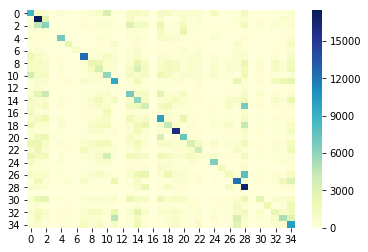

In [20]:
seaborn.heatmap(cm, cmap="YlGnBu")

In [22]:
x=[sum(cm[i]) - cm[i,i] for i in range (35)]
y=[sum(cm[i]) for i in range (35)]

In [23]:
cm_pcnt  = [cm[i]/y[i]*100 for i in range (35)]

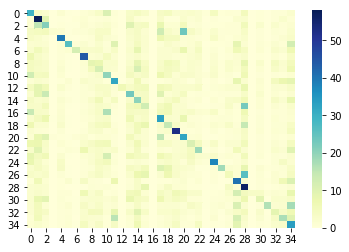

In [24]:
seaborn.heatmap(cm_pcnt, cmap="YlGnBu")

CORRELATION

In [25]:
tag_label = [(str(le.inverse_transform([i])[0])) for i in range(35)]

In [26]:
cls_report = classification_report(label_list, final, target_names=tag_label, output_dict=True)

In [26]:
outfile = "classification_report_w13_xTrainVsc.txt"
with open(outfile, "w") as f:
    f.write(cls_report)

TypeError: write() argument must be str, not dict

In [27]:
arr_f1_score = []
arr_support = []
for i in range (35):    
    arr_f1_score.append(cls_report[tag_label[i]]['f1-score'])
    arr_support.append(cls_report[tag_label[i]]['support'])                   

In [28]:
np.corrcoef(arr_f1_score, arr_support)

array([[1.        , 0.21275809],
       [0.21275809, 1.        ]])

In [29]:
scipy.stats.spearmanr(arr_f1_score, arr_support)

SpearmanrResult(correlation=0.15127109778674824, pvalue=0.38570226313754974)

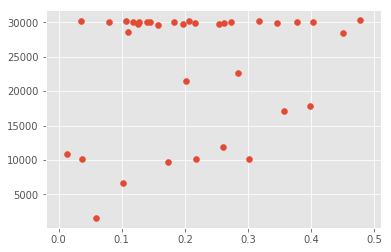

In [30]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

plt.scatter(arr_f1_score, arr_support)
plt.show()

In [31]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt

In [32]:
with open("stop_word.txt",'r') as f :
    sw = f.readlines()
for i in range (len(sw)):
    sw[i] = sw[i].strip('\n')

In [33]:
def word_cloud_plot(text,label):    
    wordcloud = WordCloud().generate(text)
    wordcloud = WordCloud(background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.savefig("word_cloud_TrainCsv_bidirect/" + label +".png")

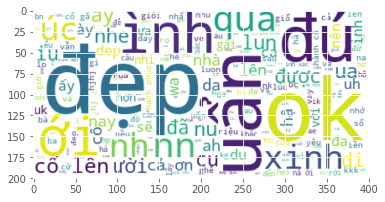

In [35]:
for i in range(35):
    data = df.status[df.target == tag_label[i]]
    text = " ".join(str(row) for row in data)   
    for j in range(len(sw)):
        text = text.replace(sw[j],'')
    if i == 4:
        text = text.replace('chị','')
    word_cloud_plot(text,tag_label[i])